# IMAGE PROCESSING

*Authored by Iulia-Maia Muresan and Marc González i Planellas*

## Objective

This file explores the obtention, processing, manipulation and adaptation of image data. The objective is to **learn how to retrieve the pixel information** of a file in a shape that is both useful as an input for the *WGAN.ipyinb* file. We do so by first working on a more simple case, the *fashion_MNIST* data, and then expanding to a full scale process generalizable to all standard image files, making a demonstration with the *SOCOFing* data.

In [1]:
import numpy as np
import os
from keras.datasets.fashion_mnist import load_data
from numpy import expand_dims
from matplotlib import pyplot
from PIL import Image, ImageOps # maybe you need to -pip install pillow

## Case 1 · Fashion MNIST

The advantage of the MNIST and Fasion MNIST data is that it can be directly sourced from keras through the `load_data()` method nested in the pertinent data set class, as seen below. We only apply a couple of standarizing transformations, and the data is good to go!

In [2]:
def load_real_samples():
    
    # We load the data and keep the labels. Each one corresponds to a clothing class (see fashion_MNIST documentation)
    (trainX, trainy), (_, _) = load_data()
    # Make a choice of what class of images we want to visualize
    selected_ix = trainy == 5
    X = trainX[selected_ix]
    # Add a channel
    X = expand_dims(X, axis=-1)
    # We need the data to be of float type
    X = X.astype('float32')
    # Scale
    X = (X - 127.5) / 127.5
    return X

The data loads nicely. We see that we have: 6000 (28x28) images with 1 channel in greyscale from -1 to 1.

In [3]:
dataset = load_real_samples()
np.shape(dataset)  

(6000, 28, 28, 1)

But... does it visualize nicely? We see that it indeed does. The data is organized as a `numpy` array of arrays, each containing continuous values from -1 to 1, corresponding to the degree of 'grayness' of every pixel. The only problem is that this image is not gray.

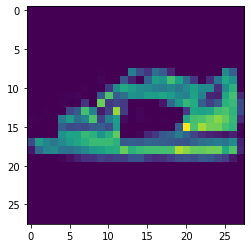

In [4]:
random_sandal_image = dataset[3]
random_sandal_image; # Take away to see the array's shape
pyplot.imshow(random_sandal_image[:,:,0])

There is an easy solution for an easy problem: we just need to force the `imshow` function to display the image in grayscale. Now, we see that -1 corresponds to absolute white and 1 to absolute black (check the array for comparison)

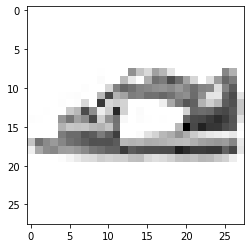

In [5]:
pyplot.imshow(random_sandal_image[:,:,0], cmap='gray_r')

The axis are ugly, so we take them away. We just want the raw image.

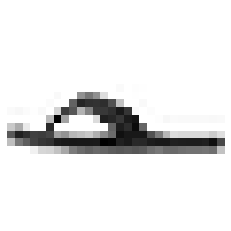

In [6]:
img = pyplot.imshow(dataset[75,:,:,0], cmap='gray_r')
pyplot.axis('off')
img

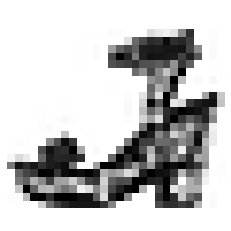

In [7]:
img = pyplot.imshow(dataset[7,:,:,0], cmap='gray_r')
pyplot.axis('off')
img

Given that a full visualization window has too big of a display (that is, the pixels are too apparent), we can design visualization windows with several shoe figures at once. The (10x10) plot looks nice, and so does the (4x4) one, although those pixels are becoming more apparent.

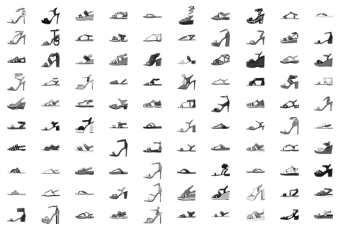

In [8]:
for i in range(10* 10):
        # define subplot
        pyplot.subplot(10, 10, 1 + i)
        # turn off axis
        pyplot.axis('off')
        # plot raw pixel data
        pyplot.imshow(dataset[i, :, :, 0], cmap='gray_r')

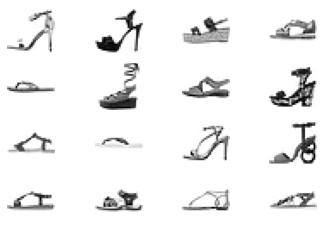

In [9]:
for i in range(4 * 4):
        # define subplot
        pyplot.subplot(4, 4, 1 + i)
        # turn off axis
        pyplot.axis('off')
        # plot raw pixel data
        pyplot.imshow(dataset[i, :, :, 0], cmap='gray_r')

## Case 2 · SOCOFing data

We will first expose with a single fingerprint image how it is loaded, what is its original structure and from there how it can be transformed to a shape suitable for the input we will use for the neural network. That shape, as we will see, will end up having the same data structure (albeit not dimension, given the number of pixels in the image), than the previously authomatically loaded *fashion_MNIST* data.

The images can be loaded to the python environment as:

In [10]:
test = Image.open("Fingerprint images/Real/1__M_Left_index_finger.bmp").resize((84,84)) # original dims (96,90)
#test

# It loads it in full color channels, while we want to have it in grayscale. This is fixed through:
test_gray = ImageOps.grayscale(test)
#test_gray

You can observe that we resize the image to a scale more apt to our purposes. We do so, because after cropping the borders as we do below, we want to have a $n\_pixels_j = 2^d \times p$ decomposition where $n\_pixels_j$ is the count of pixels in column/row (it is a square image) $j$ and some **small prime** $p$ like 2,3,5 or even 7.

The reason for this is that the GANs are mostly comprised by convolutional layers that upsample or downsample the information, and for the *WGAN.ipynb* implementation, we choose convolutional layers that output another image where $n\_pixels_j^{(i)} = \frac{n\_pixels_j^{(i-1)}}{2}$ for all rows/columns $j$ in the critic and $n\_pixels_j^{(i)} = 2*n\_pixels_j^{(i-1)}$ in the generator (for example, in the critic, an (80x80) initial input would be scaled down to (40x40), then (20x20), etc.) until the scaling is no longer applicable, moment at which a final dense layer has to be run for the activation. If the dense layer has a number $p$ of inputs that is large, the computational costs escalate dramatically.

After cropping the border, we get such a suitable decomposition, as $80=2^4\times5$

In [11]:
# Pass to array format, and crop the borders. Luckily, all the images have exactly the same borders on all sides.
test_array = np.asarray(test_gray)[1:81,1:81]#[2:90,2:90]
# Replace all the values on the first row and first column by 0s
print(test_array.shape)
print(test_array)

(80, 80)
[[114 156 156 ... 156 160 157]
 [139 255 255 ... 255 255 255]
 [137 255 255 ... 255 255 255]
 ...
 [137 255 255 ... 245 255 255]
 [142 255 255 ... 255 255 255]
 [137 255 255 ... 255 255 255]]


Afterwards, we need to apply the same process that we defined before for the *fasion_MNIST* data to standardize the pixel values.

In [12]:
# We need one dimension for the greyscale channel
test_array = expand_dims(test_array, axis=-1)
# We will need to re-scale, so converting from int to float.
test_array = test_array.astype('float32')
# Replace all the values on the first row and first column by 0s
test_array[0,:,0] = np.zeros(len(test_array[0,:,0])) + 255
test_array[:,0,0] = np.zeros(len(test_array[:,0,0])) + 255
# Now we scale into the adequate range: from [0,255] to [-1,1]
test_array = -(test_array - 127.5) / 127.5 # The minus sign is to avoid having a negative in the final image.

This corresponds to the same structure than a single image of MNIST (with the corresponding pixel size each), as we can see:

In [13]:
print("Shape of the data compared: fashion_MNIST: " + str(random_sandal_image.shape) +
      ", fingerprint: " + str(test_array.shape))

Shape of the data compared: fashion_MNIST: (28, 28, 1), fingerprint: (80, 80, 1)


Time to plot. Indeed, we see that by following this importing procedure, we get the information for images exactly as in the  MNIST data structure. Furthermore, the plot looks neat! There is a lot of information to be scraped on any given fingerprint. Also, the re-scaling to adapt it to the desired WGAN input shape does not seem to make too much of an information loss, at least qualitatively (from visual inspection).

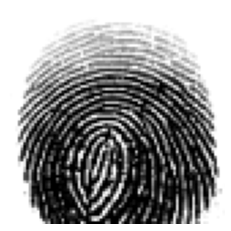

In [14]:
pyplot.imshow(test_array[:,:,0], cmap='gray_r')
pyplot.axis('off')
pyplot.show()

All-in-all, we need to generalize the following pipeline:

In [15]:
# Load image -> convert to grayscale -> convert to array -> adapt to correct n. of dims -> adapt data type -> normalize

test = Image.open("Fingerprint images/Real/1__M_Left_index_finger.bmp") 
test_gray = ImageOps.grayscale(test)
test_array = np.asarray(test_gray)[2:99,2:91]
test_array = expand_dims(test_array, axis=-1)
test_array = test_array.astype('float32')
test_array = -(test_array - 127.5) / 127.5

Which we do as follows.

In [16]:
def load_real_samples():
    X = np.empty([6000,80,80,1])
    #X = np.empty([10,103,96,1])
    path_to_image = os.listdir("Fingerprint images/Real")
    for i in range(6000):
        X_i = Image.open("Fingerprint images/Real/"+path_to_image[i]).resize((84,84))
        X_i = ImageOps.grayscale(X_i)
        X_i = np.asarray(X_i)[1:81,1:81]
        X_i = expand_dims(X_i, axis=-1) # expand to 3d, e.g. add channels
        X_i = X_i.astype('float32') # convert from ints to floats
        X_i[0,:,0] = np.zeros(80) + 255
        X_i[:,0,0] = np.zeros(80) + 255
        X_i = -(X_i - 127.5) / 127.5 # scale from [0,255] to [-1,1]
        X[i] = X_i
    return X

And then, checking that it works...

In [17]:
X = load_real_samples()
np.shape(X[0])

(80, 80, 1)

We see that it does. Great! We will use the `load_real_samples()` function within the pipeline defined in *WGAN.ipynb* to work with the SOCOFing data.

**Note:** with some minor adjustments, this process can be used to adapt any image regardless of the dimensions.

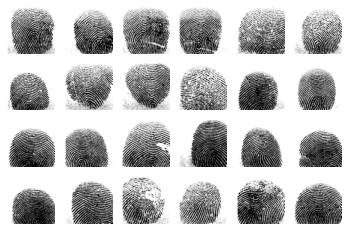

In [18]:
for i in range(4 * 6):
        # define subplot
        pyplot.subplot(4, 6, 1 + i)
        # turn off axis
        pyplot.axis('off')
        # plot raw pixel data
        pyplot.imshow(X[i, :, :, 0], cmap='gray_r')